In [1]:
import pandas as pd # jason branch
import numpy as np
import os
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

/tmp/ipykernel_2818/1601000250.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2025-10-28 18:33:04.814686: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-28 18:33:04.864114: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-28 18:33:04.864175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin 

In [2]:
folders = ["damage", "no_damage"]

data = []
for folder in folders:
    folder_path = folder
    for fname in os.listdir(folder_path):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(folder_path, fname)
            # Load the RGB image (128x128)
            img = load_img(img_path, target_size=(128, 128))
            img_array = img_to_array(img) / 255.0  # normalize
            img_array = img_array.flatten()  # flatten for ANN
            data.append({
                "image_path": img_array,   # store pixel array instead of path
                "label": folder
            })

data = pd.DataFrame(data)
print(data.head())
data.tail

                                          image_path   label
0  [0.26666668, 0.32941177, 0.21568628, 0.2627451...  damage
1  [0.4117647, 0.40392157, 0.3137255, 0.43137255,...  damage
2  [0.3019608, 0.34901962, 0.3019608, 0.29803923,...  damage
3  [0.47058824, 0.48235294, 0.36862746, 0.4588235...  damage
4  [0.23137255, 0.32941177, 0.1764706, 0.21176471...  damage


<bound method NDFrame.tail of                                               image_path      label
0      [0.26666668, 0.32941177, 0.21568628, 0.2627451...     damage
1      [0.4117647, 0.40392157, 0.3137255, 0.43137255,...     damage
2      [0.3019608, 0.34901962, 0.3019608, 0.29803923,...     damage
3      [0.47058824, 0.48235294, 0.36862746, 0.4588235...     damage
4      [0.23137255, 0.32941177, 0.1764706, 0.21176471...     damage
...                                                  ...        ...
21317  [0.32156864, 0.34509805, 0.23529412, 0.3372549...  no_damage
21318  [0.1764706, 0.23137255, 0.16470589, 0.18431373...  no_damage
21319  [0.2, 0.25490198, 0.15686275, 0.22745098, 0.28...  no_damage
21320  [0.35686275, 0.3882353, 0.29411766, 0.36078432...  no_damage
21321  [0.5254902, 0.54901963, 0.4392157, 0.49803922,...  no_damage

[21322 rows x 2 columns]>

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21322 entries, 0 to 21321
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  21322 non-null  object
 1   label       21322 non-null  object
dtypes: object(2)
memory usage: 333.3+ KB


In [4]:
data.size

42644

In [5]:
img = Image.open("damage/-93.795_30.03779.jpeg")
img.size


(128, 128)

In [6]:
data["label"]

0           damage
1           damage
2           damage
3           damage
4           damage
           ...    
21317    no_damage
21318    no_damage
21319    no_damage
21320    no_damage
21321    no_damage
Name: label, Length: 21322, dtype: object

In [7]:
data['label'] = data['label'].astype("string")
data = pd.get_dummies(data, columns=["label"], drop_first=True)

In [8]:
data.columns

Index(['image_path', 'label_no_damage'], dtype='object')

In [9]:
data.head

<bound method NDFrame.head of                                               image_path  label_no_damage
0      [0.26666668, 0.32941177, 0.21568628, 0.2627451...            False
1      [0.4117647, 0.40392157, 0.3137255, 0.43137255,...            False
2      [0.3019608, 0.34901962, 0.3019608, 0.29803923,...            False
3      [0.47058824, 0.48235294, 0.36862746, 0.4588235...            False
4      [0.23137255, 0.32941177, 0.1764706, 0.21176471...            False
...                                                  ...              ...
21317  [0.32156864, 0.34509805, 0.23529412, 0.3372549...             True
21318  [0.1764706, 0.23137255, 0.16470589, 0.18431373...             True
21319  [0.2, 0.25490198, 0.15686275, 0.22745098, 0.28...             True
21320  [0.35686275, 0.3882353, 0.29411766, 0.36078432...             True
21321  [0.5254902, 0.54901963, 0.4392157, 0.49803922,...             True

[21322 rows x 2 columns]>

In [10]:
data['label_no_damage'] = data['label_no_damage'].apply(lambda x: 1 if x == False else 0)
data.info()
data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21322 entries, 0 to 21321
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_path       21322 non-null  object
 1   label_no_damage  21322 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 333.3+ KB


image_path         0
label_no_damage    0
dtype: int64

In [11]:
data.head

<bound method NDFrame.head of                                               image_path  label_no_damage
0      [0.26666668, 0.32941177, 0.21568628, 0.2627451...                1
1      [0.4117647, 0.40392157, 0.3137255, 0.43137255,...                1
2      [0.3019608, 0.34901962, 0.3019608, 0.29803923,...                1
3      [0.47058824, 0.48235294, 0.36862746, 0.4588235...                1
4      [0.23137255, 0.32941177, 0.1764706, 0.21176471...                1
...                                                  ...              ...
21317  [0.32156864, 0.34509805, 0.23529412, 0.3372549...                0
21318  [0.1764706, 0.23137255, 0.16470589, 0.18431373...                0
21319  [0.2, 0.25490198, 0.15686275, 0.22745098, 0.28...                0
21320  [0.35686275, 0.3882353, 0.29411766, 0.36078432...                0
21321  [0.5254902, 0.54901963, 0.4392157, 0.49803922,...                0

[21322 rows x 2 columns]>

Damage is 1, no damage is 0

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
X = np.stack(data["image_path"].values)
Y = data["label_no_damage"].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)

In [13]:
data.head

<bound method NDFrame.head of                                               image_path  label_no_damage
0      [0.26666668, 0.32941177, 0.21568628, 0.2627451...                1
1      [0.4117647, 0.40392157, 0.3137255, 0.43137255,...                1
2      [0.3019608, 0.34901962, 0.3019608, 0.29803923,...                1
3      [0.47058824, 0.48235294, 0.36862746, 0.4588235...                1
4      [0.23137255, 0.32941177, 0.1764706, 0.21176471...                1
...                                                  ...              ...
21317  [0.32156864, 0.34509805, 0.23529412, 0.3372549...                0
21318  [0.1764706, 0.23137255, 0.16470589, 0.18431373...                0
21319  [0.2, 0.25490198, 0.15686275, 0.22745098, 0.28...                0
21320  [0.35686275, 0.3882353, 0.29411766, 0.36078432...                0
21321  [0.5254902, 0.54901963, 0.4392157, 0.49803922,...                0

[21322 rows x 2 columns]>

In [33]:
#ANN
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(128*128*3,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, validation_split=0.2, epochs=10, batch_size=128, verbose=2)

Epoch 1/10


2025-10-28 18:10:14.993101: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2347499520 exceeds 10% of free system memory.


94/94 - 18s - loss: 1.8405 - accuracy: 0.5931 - val_loss: 0.5878 - val_accuracy: 0.7018 - 18s/epoch - 196ms/step
Epoch 2/10
94/94 - 17s - loss: 0.6173 - accuracy: 0.6745 - val_loss: 0.6778 - val_accuracy: 0.5635 - 17s/epoch - 181ms/step
Epoch 3/10
94/94 - 17s - loss: 0.5745 - accuracy: 0.7109 - val_loss: 0.5521 - val_accuracy: 0.7427 - 17s/epoch - 181ms/step
Epoch 4/10
94/94 - 17s - loss: 0.5819 - accuracy: 0.7140 - val_loss: 0.7207 - val_accuracy: 0.6754 - 17s/epoch - 184ms/step
Epoch 5/10
94/94 - 17s - loss: 0.5922 - accuracy: 0.6922 - val_loss: 0.5555 - val_accuracy: 0.7430 - 17s/epoch - 182ms/step
Epoch 6/10
94/94 - 17s - loss: 0.5565 - accuracy: 0.7308 - val_loss: 0.5844 - val_accuracy: 0.6905 - 17s/epoch - 181ms/step
Epoch 7/10
94/94 - 17s - loss: 0.5620 - accuracy: 0.7225 - val_loss: 0.5476 - val_accuracy: 0.7524 - 17s/epoch - 182ms/step
Epoch 8/10
94/94 - 17s - loss: 0.5528 - accuracy: 0.7322 - val_loss: 0.5570 - val_accuracy: 0.7303 - 17s/epoch - 183ms/step
Epoch 9/10
94/94 - 

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               25166336  
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 25314177 (96.57 MB)
Trainable params: 25314177 (96.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
y_pred = model.predict(X_test)

200/200 [==============================] - 2s 8ms/step


In [38]:
y_pred[0]

array([0.5169948], dtype=float32)

In [39]:
len(y_pred)

6397

In [40]:
import numpy as np
y_pred_final=[]
for i in y_pred:
    # return the index with the highest probability
    if i > .50:
        y_pred_final.append(1)
    else:
        y_pred_final.append(0)

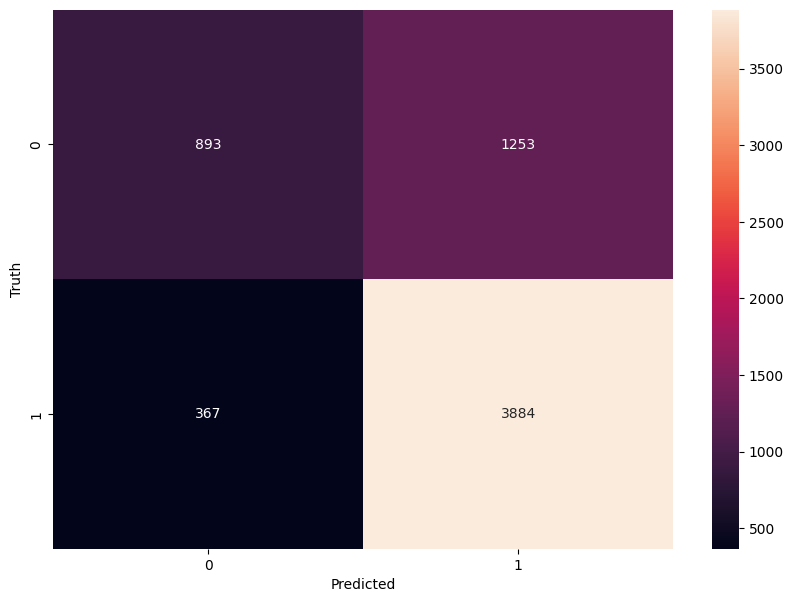

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm=confusion_matrix(Y_test,y_pred_final)

plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [42]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred_final))

              precision    recall  f1-score   support

           0       0.71      0.42      0.52      2146
           1       0.76      0.91      0.83      4251

    accuracy                           0.75      6397
   macro avg       0.73      0.66      0.68      6397
weighted avg       0.74      0.75      0.73      6397



In [2]:
folders = ["damage", "no_damage"]

dataCNN = []
for folder in folders:
    folder_path = folder
    for fname in os.listdir(folder_path):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(folder_path, fname)
            # Load the RGB image (128x128)
            img = load_img(img_path, target_size=(128, 128))
            img_array = img_to_array(img) / 255.0  # normalize
            dataCNN.append({
                "image_path": img_array,   # store pixel array instead of path
                "label": folder
            })

dataCNN = pd.DataFrame(dataCNN)
print(dataCNN.head())
dataCNN.tail

                                          image_path   label
0  [[[0.26666668, 0.32941177, 0.21568628], [0.262...  damage
1  [[[0.4117647, 0.40392157, 0.3137255], [0.43137...  damage
2  [[[0.3019608, 0.34901962, 0.3019608], [0.29803...  damage
3  [[[0.47058824, 0.48235294, 0.36862746], [0.458...  damage
4  [[[0.23137255, 0.32941177, 0.1764706], [0.2117...  damage


<bound method NDFrame.tail of                                               image_path      label
0      [[[0.26666668, 0.32941177, 0.21568628], [0.262...     damage
1      [[[0.4117647, 0.40392157, 0.3137255], [0.43137...     damage
2      [[[0.3019608, 0.34901962, 0.3019608], [0.29803...     damage
3      [[[0.47058824, 0.48235294, 0.36862746], [0.458...     damage
4      [[[0.23137255, 0.32941177, 0.1764706], [0.2117...     damage
...                                                  ...        ...
21317  [[[0.32156864, 0.34509805, 0.23529412], [0.337...  no_damage
21318  [[[0.1764706, 0.23137255, 0.16470589], [0.1843...  no_damage
21319  [[[0.2, 0.25490198, 0.15686275], [0.22745098, ...  no_damage
21320  [[[0.35686275, 0.3882353, 0.29411766], [0.3607...  no_damage
21321  [[[0.5254902, 0.54901963, 0.4392157], [0.49803...  no_damage

[21322 rows x 2 columns]>

In [3]:
dataCNN.size

42644

In [4]:
len(dataCNN['image_path'][0])

128

In [5]:
dataCNN['image_path'][0].shape

(128, 128, 3)

In [6]:
dataCNN['label'] = dataCNN['label'].astype("string")
dataCNN = pd.get_dummies(dataCNN, columns=["label"], drop_first=True)

In [7]:
dataCNN['label_no_damage'] = dataCNN['label_no_damage'].apply(lambda x: 1 if x == False else 0)
dataCNN.info()
dataCNN.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21322 entries, 0 to 21321
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_path       21322 non-null  object
 1   label_no_damage  21322 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 333.3+ KB


image_path         0
label_no_damage    0
dtype: int64

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
X = np.stack(dataCNN["image_path"].values)
Y = dataCNN["label_no_damage"].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)

In [9]:
X_train.shape

(14925, 128, 128, 3)

In [12]:
# Importing all the different layers and optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

# Intializing a sequential model
model_cnn = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of MNIST images
model_cnn.add(Conv2D(64, (4, 4), activation='relu', padding="same", input_shape=(128, 128, 3)))
# Adding max pooling to reduce the size of output of first conv layer
model_cnn.add(MaxPooling2D((2, 2), padding = 'same'))

model_cnn.add(Conv2D(32, (4, 4), activation='relu', padding="same"))
model_cnn.add(MaxPooling2D((2, 2), padding = 'same'))

model_cnn.add(Conv2D(32, (4, 4), activation='relu', padding="same"))
model_cnn.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model_cnn.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model_cnn.add(Dense(100, activation='relu'))

model_cnn.add(Dense(1, activation='sigmoid'))


model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.fit(X_train, Y_train, validation_split=0.2, epochs=10, batch_size=128, verbose=2)


Epoch 1/10


2025-10-28 18:34:20.693392: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2347499520 exceeds 10% of free system memory.


94/94 - 156s - loss: 0.5677 - accuracy: 0.7118 - val_loss: 0.4760 - val_accuracy: 0.7360 - 156s/epoch - 2s/step
Epoch 2/10


KeyboardInterrupt: 

In [1]:
chris


NameError: name 'chris' is not defined